# Prompting Experiments & Stability Analysis

Compares steering vectors against few-shot prompting baselines and analyzes behavioral stability.

**Prompting Comparison**:
- Steering vector (Llama-70B) vs few-shot prompting (Claude-3.7, GPT-4o)
- LLM-as-judge ratings for coherence and relationship-seeking
- Pairwise head-to-head comparisons
- Mixed-effects regression analysis

**Stability Analysis**:
- Persona attack experiments across conversation turns
- Comparison of steering vs prompting robustness

In [1]:
import json
import os
import sys
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc

# Add paths for shared imports
REPO_ROOT = Path("../..").resolve()
PROJECT_ROOT = Path("..").resolve()  # 2-steering-vector-training
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))

from setup.plot_config import (
    PASTEL2,
    SET2,
    set_pub_style,
    save_fig,
)

# Set paths
VECTOR_DIR = PROJECT_ROOT / "vector"
VECTOR_EVALS_DIR = PROJECT_ROOT / "vector_evals"
PROMPT_BASELINE_DIR = PROJECT_ROOT / "prompting_experiments" / "exp1_steerability"
STABILITY_DIR = PROJECT_ROOT / "prompting_experiments" / "exp2_stability"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIGURE_DIR = OUTPUT_DIR / "figures"
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Apply publication style
set_pub_style()

Publication style loaded (font: Arial)


## Configuration

In [2]:
# Steering vector configuration (optimal selection from behavioral evals)
STEERING_CONFIG = {
    "model": "Llama-3.1-70B-Instruct",
    "layer": 31,
    "epoch": 10,
}

# Prompting baseline configuration
N_LEVELS = 7  # Number of prompting levels

# Multiplier range for analysis
MULTIPLIER_RANGE = (-1.5, 1.5)

## Load Data

In [3]:
def load_steering_data():
    """Load steering vector evaluation data for the selected configuration."""
    model = STEERING_CONFIG["model"]
    layer = STEERING_CONFIG["layer"]
    epoch = STEERING_CONFIG["epoch"]

    experiment_dir = VECTOR_EVALS_DIR / model / f"layer{layer}"

    data = {}
    files = {
        "coherence": experiment_dir / f"coherence_scores_ep{epoch}.jsonl",
        "relationship": experiment_dir / f"relationship_scores_ep{epoch}.jsonl",
    }

    for key, filepath in files.items():
        if filepath.exists():
            with open(filepath, "r") as f:
                data[key] = pd.read_json(StringIO(f.read()), lines=True)
            print(f"Loaded {len(data[key])} {key} scores for steering vector")
        else:
            print(f"Missing: {filepath}")

    return data


def load_prompting_baselines():
    """Load few-shot prompting baseline data for Claude and GPT."""
    baseline_store = {}

    for model in [f"gpt_levels_{N_LEVELS}", f"claude_levels_{N_LEVELS}"]:
        baseline_store[model] = {}
        for task in ["coherence", "relationship"]:
            file_path = PROMPT_BASELINE_DIR / model / f"{task}_scores.jsonl"
            if file_path.exists():
                with open(file_path, "r") as f:
                    baseline_store[model][task] = pd.read_json(f, lines=True)
                print(
                    f"Loaded {len(baseline_store[model][task])} {task} scores for {model}"
                )
            else:
                print(f"Missing: {file_path}")

    return baseline_store


# Load all data
steering_data = load_steering_data()
baseline_store = load_prompting_baselines()

Loaded 5145 coherence scores for steering vector
Loaded 5145 relationship scores for steering vector
Loaded 1715 coherence scores for gpt_levels_7
Loaded 1715 relationship scores for gpt_levels_7
Loaded 1715 coherence scores for claude_levels_7
Loaded 1715 relationship scores for claude_levels_7


In [4]:
# Count prompting experiment entries
total_steering = sum(len(df) for df in steering_data.values())
total_baseline = sum(
    len(df) for model_data in baseline_store.values() for df in model_data.values()
)

print(f"Steering vector scores: {total_steering:,}")
print(f"Prompting baseline scores: {total_baseline:,}")
print(f"\nTotal prompting experiment scores: {total_steering + total_baseline:,}")

Steering vector scores: 10,290
Prompting baseline scores: 6,860

Total prompting experiment scores: 17,150


## Steering vs Prompting Comparison

In [5]:
def plot_prompt_comparison_metrics(
    steering_data, baseline_store, multiplier_range=(-2, 2), figsize=(18, 6)
):
    """
    Create side-by-side plots comparing coherence and relationship metrics for three approaches:
    Llama steering vector, Claude prompting, and GPT prompting.
    """

    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

    # Define models and their data sources
    models = [
        "Llama-70B (L31, EP10)\n+ Steering Vec",
        f"Claude-3.7\n+ Few-Shot Prompting",
        f"GPT-4o\n+ Few-Shot Prompting",
    ]
    data_sources = [
        steering_data,
        baseline_store[f"claude_levels_{N_LEVELS}"],
        baseline_store[f"gpt_levels_{N_LEVELS}"],
    ]

    # Colors (matching behavioral evals)
    coherence_color = "blue"
    relationship_color = "green"

    # Process each model
    for i, (model, data_source) in enumerate(zip(models, data_sources)):
        ax = axes[i]

        # Process data for each task
        for task in ["coherence", "relationship"]:
            df = data_source[task]

            # Filter multipliers in range
            plot_df = df[
                (df["multiplier"] >= multiplier_range[0])
                & (df["multiplier"] <= multiplier_range[1])
            ].copy()

            # Group by multiplier
            grouped = (
                plot_df.groupby("multiplier")["score"]
                .agg(["mean", "std"])
                .reset_index()
            )
            x_values = grouped["multiplier"]
            y_values = grouped["mean"]
            y_err = grouped["std"]

            # Choose color and marker
            current_color = (
                coherence_color if task == "coherence" else relationship_color
            )
            marker = "o" if task == "coherence" else "s"

            # Plot the data
            ax.plot(
                x_values,
                y_values,
                color=current_color,
                marker=marker,
                alpha=0.7,
                linewidth=2,
                markersize=6,
            )
            ax.fill_between(
                x_values,
                y_values - y_err,
                y_values + y_err,
                alpha=0.1,
                color=current_color,
            )

            # Add metrics annotations
            if task == "coherence":
                auc_value = auc(x_values, y_values)
                ax.text(
                    0.95,
                    0.2,
                    f"AUC: {auc_value:.2f}",
                    transform=ax.transAxes,
                    color=coherence_color,
                    va="top",
                    ha="right",
                )
            else:
                # Calculate linear regression
                slope, intercept, _, p_val, _ = stats.linregress(x_values, y_values)

                # Add regression line
                ax.plot(
                    x_values,
                    slope * x_values + intercept,
                    linestyle="--",
                    color="black",
                    alpha=0.7,
                )

                # Add significance stars
                stars = (
                    "***"
                    if p_val < 0.001
                    else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                )

                ax.text(
                    0.95,
                    0.1,
                    f"$\\beta$: {slope:.2f}{stars}",
                    transform=ax.transAxes,
                    color=relationship_color,
                    va="top",
                    ha="right",
                )

        # Styling
        ax.set_ylim(0, 10)
        ax.set_xlim(multiplier_range[0] - 0.1, multiplier_range[1] + 0.1)
        ax.set_title(model, fontweight="semibold")

        if i == 0:
            ax.set_ylabel("Rating (1-10)")
            ax.set_xlabel(r"Multiplier ($\lambda$)")
        else:
            ax.set_xlabel(
                r"Effective Multiplier ($\lambda$)" + "\n" + r"(mapped from level)"
            )

    # Legend
    coherence_line = mlines.Line2D(
        [], [], color=coherence_color, marker="o", label="Coherence"
    )
    relationship_line = mlines.Line2D(
        [], [], color=relationship_color, marker="s", label="Relationship-Seeking"
    )
    fig.legend(
        handles=[coherence_line, relationship_line],
        loc="upper center",
        bbox_to_anchor=(0.5, 0.075),
        ncol=2,
        frameon=False,
        markerscale=1.5,
    )

    plt.tight_layout(rect=[0.02, 0.08, 0.98, 0.95])

    return fig

Saved: prompting_experiment_ratings


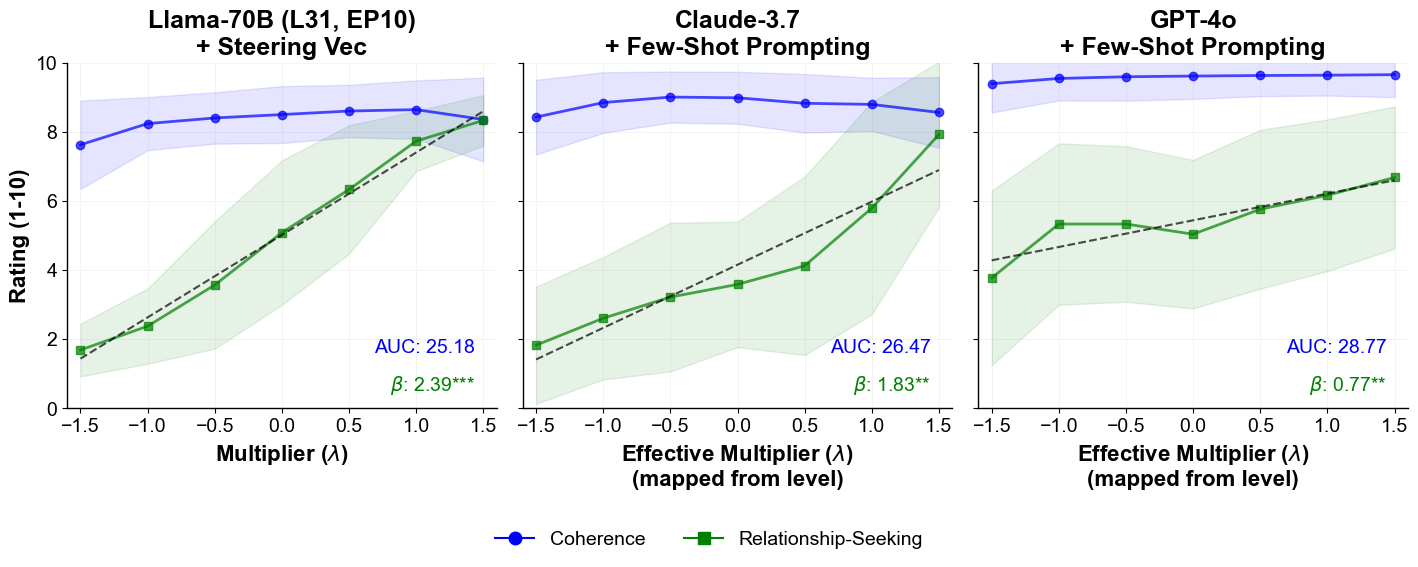

In [6]:
fig_comparison = plot_prompt_comparison_metrics(
    steering_data, baseline_store, multiplier_range=MULTIPLIER_RANGE, figsize=(15, 6)
)
save_fig(fig_comparison, FIGURE_DIR, "prompting_experiment_ratings")
plt.show()

## Pairwise Head-to-Head Comparisons

In [7]:
def plot_steering_effectiveness(steering_config, figsize=(16, 10)):
    """
    Plot steering effectiveness with raw win rates and corrected overall success.
    Uses green/red color scheme for positive/negative multipliers.
    """

    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Color scheme
    colors = {
        "negative": "#F5A5A5",  # Light red for negative multipliers
        "positive": "#A8D8A8",  # Light green for positive multipliers
        "zero": "#D3D3D3",  # Light gray for zero
    }

    baselines = ["Claude-3.7", "GPT-4o"]
    models_map = {"Claude-3.7": "claude", "GPT-4o": "gpt"}

    vector_model = steering_config["model"]
    layer = steering_config["layer"]
    epoch = steering_config["epoch"]

    for baseline_idx, baseline in enumerate(baselines):
        model = models_map[baseline]

        # Load pairwise comparison data
        file_path = (
            PROMPT_BASELINE_DIR
            / f"{model}_levels_{N_LEVELS}"
            / f"ranking_{model}_vs_steering_{vector_model}_layer{layer}_ep{epoch}.jsonl"
        )
        pairwise_df = pd.read_json(file_path, lines=True)

        # 1. Per-multiplier raw win rates (top row)
        ax_detail = axes[0, baseline_idx]

        multipliers = sorted(pairwise_df["steering_multiplier"].unique())
        win_rates = []
        bar_colors = []

        for multiplier in multipliers:
            mult_data = pairwise_df[pairwise_df["steering_multiplier"] == multiplier]
            win_rate = (mult_data["winner"] == "steering_vector").mean() * 100
            win_rates.append(win_rate)

            if multiplier < 0:
                bar_colors.append(colors["negative"])
            elif multiplier > 0:
                bar_colors.append(colors["positive"])
            else:
                bar_colors.append(colors["zero"])

        bars = ax_detail.bar(
            range(len(multipliers)),
            win_rates,
            color=bar_colors,
            alpha=0.8,
            edgecolor="white",
            linewidth=1,
        )

        ax_detail.axhline(y=50, color="black", linestyle="--", alpha=0.7)

        for bar, rate in zip(bars, win_rates):
            ax_detail.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 1,
                f"{rate:.1f}%",
                ha="center",
                va="bottom",
                fontweight="bold",
            )

        ax_detail.set_title(f"Raw Win Rates vs {baseline}", fontweight="semibold")
        ax_detail.set_ylabel(
            "Steering Vector Win Rate (%)" if baseline_idx == 0 else ""
        )
        ax_detail.set_xticks(range(len(multipliers)))
        ax_detail.set_xticklabels([f"{m:.1f}" for m in multipliers])
        ax_detail.set_xlabel(r"(Effective) Multiplier ($\lambda$)")
        ax_detail.set_ylim(0, 100)

        # 2. Overall effectiveness (bottom row)
        ax_overall = axes[1, baseline_idx]

        negative_data = pairwise_df[pairwise_df["steering_multiplier"] < 0]
        positive_data = pairwise_df[pairwise_df["steering_multiplier"] > 0]

        # Raw win rates
        negative_win_rate = (
            (negative_data["winner"] == "steering_vector").mean() * 100
            if len(negative_data) > 0
            else 0
        )
        positive_win_rate = (
            (positive_data["winner"] == "steering_vector").mean() * 100
            if len(positive_data) > 0
            else 0
        )

        # Corrected success rates
        negative_success = (
            (negative_data["winner"] != "steering_vector").mean() * 100
            if len(negative_data) > 0
            else 0
        )  # Success = losing for negative
        positive_success = (
            (positive_data["winner"] == "steering_vector").mean() * 100
            if len(positive_data) > 0
            else 0
        )  # Success = winning for positive
        overall_success = (negative_success + positive_success) / 2

        categories = [
            "Reducing\n(Raw Win Rate)",
            "Increasing\n(Raw Win Rate)",
            "Overall\n(Corrected Success)",
        ]
        values = [negative_win_rate, positive_win_rate, overall_success]
        bar_colors_overall = [colors["negative"], colors["positive"], "#cbd5e8"]

        bars_overall = ax_overall.bar(
            categories,
            values,
            color=bar_colors_overall,
            alpha=0.8,
            edgecolor="white",
            linewidth=1,
        )

        ax_overall.axhline(y=50, color="black", linestyle="--", alpha=0.7)

        for bar, value in zip(bars_overall, values):
            ax_overall.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 1,
                f"{value:.1f}%",
                ha="center",
                va="bottom",
                fontweight="bold",
            )

        ax_overall.set_title(
            f"Overall Effectiveness vs {baseline}", fontweight="semibold"
        )
        ax_overall.set_ylabel("Rate (%)" if baseline_idx == 0 else "")
        ax_overall.set_ylim(0, 100)

    # Legend
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor=colors["negative"],
            alpha=0.8,
            label=r"$\lambda$ < 0 (Decreasing relationship-seeking)",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor=colors["positive"],
            alpha=0.8,
            label=r"$\lambda$ > 0 (Increasing relationship-seeking)",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor=colors["zero"],
            alpha=0.8,
            label=r"$\lambda$ = 0 (No steering)",
        ),
    ]

    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=3,
        frameon=False,
    )

    # plt.suptitle(
    #     f"Pairwise Head-to-Head Steering Effectiveness: {vector_model} (L{layer}, E{epoch})",
    #     fontstyle="italic",
    # )

    plt.tight_layout(rect=[0.02, 0.08, 0.98, 0.92])

    return fig

Saved: prompting_experiment_rankings


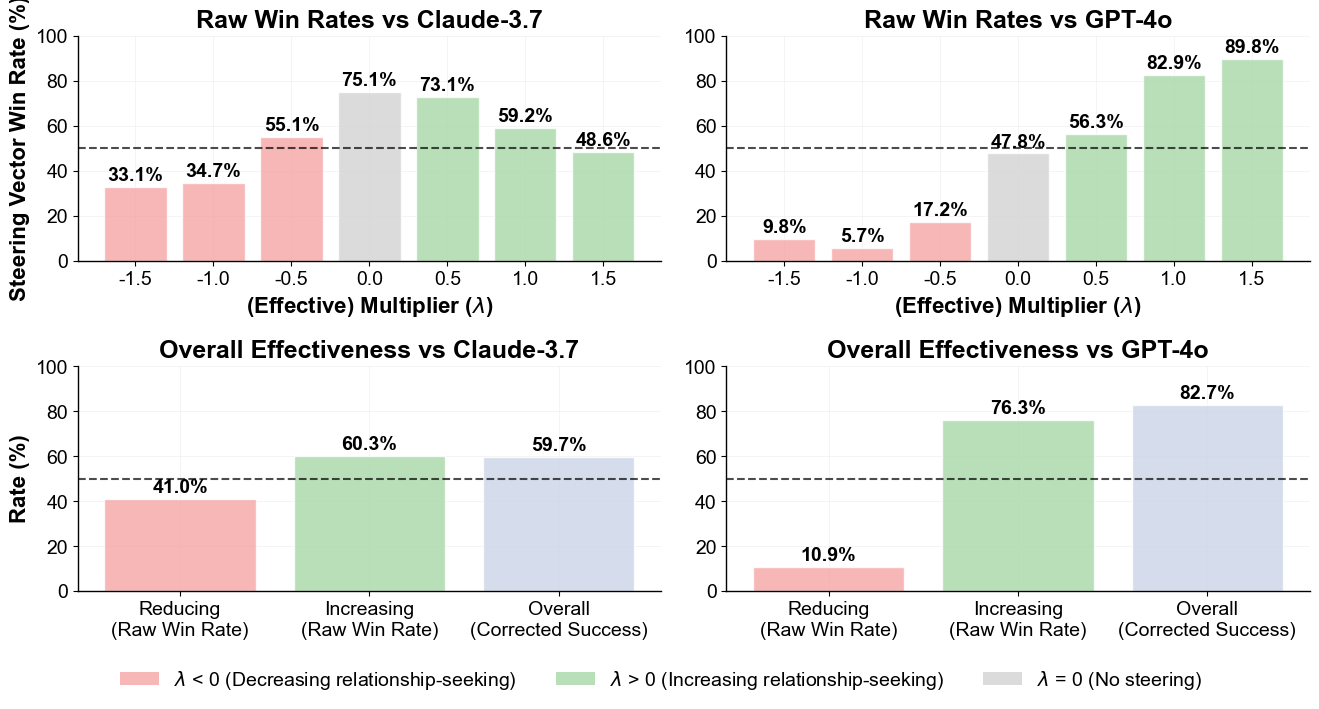

In [8]:
fig_effectiveness = plot_steering_effectiveness(STEERING_CONFIG, figsize=(14, 8))
save_fig(fig_effectiveness, FIGURE_DIR, "prompting_experiment_rankings")
plt.show()

## Mixed-Effects Regression Analysis

In [9]:
def regression_analysis_mixed_effects(
    steering_data, baseline_store, multiplier_range=(-2, 2)
):
    """
    Mixed-effects regression analysis for steering vs prompting comparison.

    Model: score ~ (multiplier + multiplier^2) * model + (1|prompt_id)
    """
    from statsmodels.formula.api import mixedlm

    # Define models and their data sources
    models = ["Llama-70B", "Claude-3.7", "GPT-4o"]
    data_sources = [
        steering_data,
        baseline_store[f"claude_levels_{N_LEVELS}"],
        baseline_store[f"gpt_levels_{N_LEVELS}"],
    ]

    results = {}

    for metric in ["relationship", "coherence"]:
        print(f"\n{'='*60}")
        print(f"MIXED-EFFECTS REGRESSION: {metric.upper()} SCORES")
        print(f"{'='*60}")

        # Combine all data into single dataframe
        all_data = []
        for model_name, data_source in zip(models, data_sources):
            df = data_source[metric].copy()

            df = df[
                (df["multiplier"] >= multiplier_range[0])
                & (df["multiplier"] <= multiplier_range[1])
            ]

            df["model"] = model_name
            all_data.append(df)

        combined_df = pd.concat(all_data, ignore_index=True)

        # Create categorical model variable with Llama as reference
        combined_df["model_cat"] = pd.Categorical(
            combined_df["model"], categories=models, ordered=False
        )

        print(f"Dataset: {len(combined_df)} observations")
        print(f"Models: {dict(combined_df['model'].value_counts())}")
        print(f"Unique prompts: {combined_df['test_prompt_id'].nunique()}")

        # Fit mixed-effects model
        try:
            print(f"\n--- MIXED-EFFECTS MODEL ---")
            print(
                "Formula: score ~ (multiplier + I(multiplier**2)) * C(model_cat) + (1|test_prompt_id)"
            )

            model = mixedlm(
                "score ~ (multiplier + I(multiplier**2)) * C(model_cat)",
                data=combined_df,
                groups=combined_df["test_prompt_id"],
            ).fit()

            print(model.summary())

            # Variance components
            random_effect_var = model.cov_re.iloc[0, 0]
            residual_var = model.scale
            icc = random_effect_var / (random_effect_var + residual_var)

            print(f"\n--- VARIANCE COMPONENTS ---")
            print(
                f"Random intercept variance (test_prompt_id): {random_effect_var:.4f}"
            )
            print(f"Residual variance: {residual_var:.4f}")
            print(f"Intraclass correlation (ICC): {icc:.4f}")
            print(
                f"Interpretation: {icc*100:.1f}% of variance due to prompt differences"
            )

        except Exception as e:
            print(f"Mixed-effects model failed: {e}")
            from statsmodels.formula.api import ols

            model = ols(
                "score ~ (multiplier + I(multiplier**2)) * C(model_cat)",
                data=combined_df,
            ).fit()
            print(model.summary())

        results[metric] = {
            "data": combined_df,
            "model": model,
            "params": model.params,
            "pvalues": model.pvalues,
        }

    return results

In [10]:
regression_results = regression_analysis_mixed_effects(
    steering_data, baseline_store, multiplier_range=MULTIPLIER_RANGE
)


MIXED-EFFECTS REGRESSION: RELATIONSHIP SCORES
Dataset: 5145 observations
Models: {'Llama-70B': np.int64(1715), 'Claude-3.7': np.int64(1715), 'GPT-4o': np.int64(1715)}
Unique prompts: 245

--- MIXED-EFFECTS MODEL ---
Formula: score ~ (multiplier + I(multiplier**2)) * C(model_cat) + (1|test_prompt_id)
                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            score     
No. Observations:            5145               Method:                        REML      
No. Groups:                  245                Scale:                         2.3975    
Min. group size:             21                 Log-Likelihood:                -9905.2479
Max. group size:             21                 Converged:                     Yes       
Mean group size:             21.0                                                        
-----------------------------------------------------------------------------------------
    

Saved: mixed_effects_coefficients


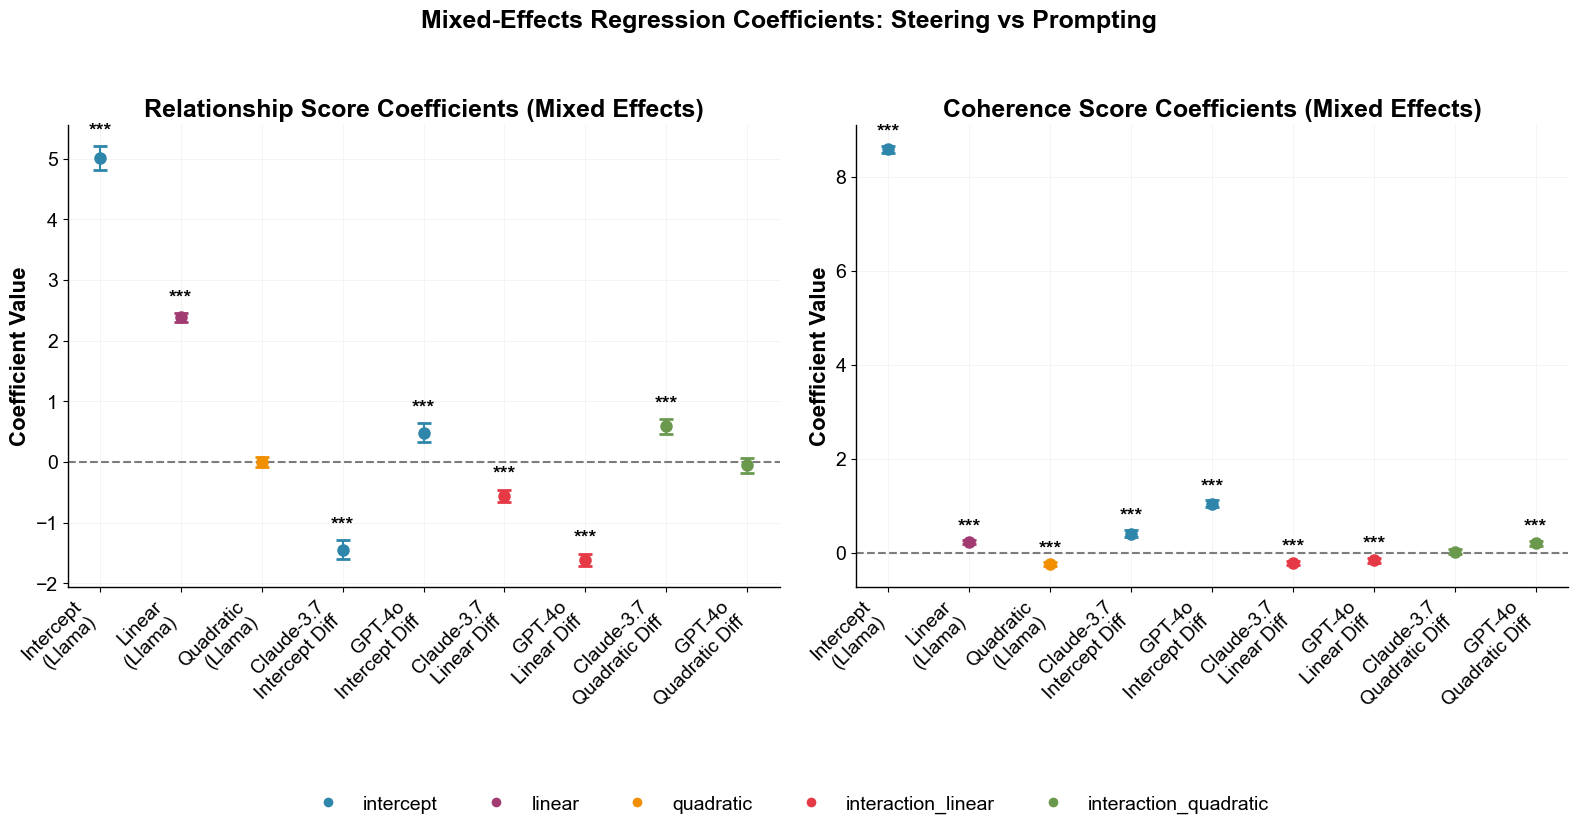

In [11]:
def plot_mixed_effects_coefficients(results):
    """
    Plot mixed-effects regression coefficients for both metrics side by side.
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    colors = {
        "intercept": "#2E86AB",
        "linear": "#A23B72",
        "quadratic": "#F18F01",
        "interaction_linear": "#E63946",
        "interaction_quadratic": "#6A994E",
    }

    for i, (metric, result) in enumerate(results.items()):
        ax = axes[i]

        model = result["model"]
        params = model.params
        pvalues = model.pvalues
        se = model.bse
        conf_int_lower = params - 1.96 * se
        conf_int_upper = params + 1.96 * se

        coef_data = []

        # Intercept
        coef_data.append(
            {
                "name": "Intercept\n(Llama)",
                "value": params["Intercept"],
                "pvalue": pvalues["Intercept"],
                "lower": conf_int_lower["Intercept"],
                "upper": conf_int_upper["Intercept"],
                "type": "intercept",
            }
        )

        # Main effects
        if "multiplier" in params:
            coef_data.append(
                {
                    "name": "Linear\n(Llama)",
                    "value": params["multiplier"],
                    "pvalue": pvalues["multiplier"],
                    "lower": conf_int_lower["multiplier"],
                    "upper": conf_int_upper["multiplier"],
                    "type": "linear",
                }
            )

        if "I(multiplier ** 2)" in params:
            coef_data.append(
                {
                    "name": "Quadratic\n(Llama)",
                    "value": params["I(multiplier ** 2)"],
                    "pvalue": pvalues["I(multiplier ** 2)"],
                    "lower": conf_int_lower["I(multiplier ** 2)"],
                    "upper": conf_int_upper["I(multiplier ** 2)"],
                    "type": "quadratic",
                }
            )

        # Model differences
        for model_name in ["Claude-3.7", "GPT-4o"]:
            coef_name = f"C(model_cat)[T.{model_name}]"
            if coef_name in params:
                coef_data.append(
                    {
                        "name": f"{model_name}\nIntercept Diff",
                        "value": params[coef_name],
                        "pvalue": pvalues[coef_name],
                        "lower": conf_int_lower[coef_name],
                        "upper": conf_int_upper[coef_name],
                        "type": "intercept",
                    }
                )

        # Linear interactions
        for model_name in ["Claude-3.7", "GPT-4o"]:
            coef_name = f"multiplier:C(model_cat)[T.{model_name}]"
            if coef_name in params:
                coef_data.append(
                    {
                        "name": f"{model_name}\nLinear Diff",
                        "value": params[coef_name],
                        "pvalue": pvalues[coef_name],
                        "lower": conf_int_lower[coef_name],
                        "upper": conf_int_upper[coef_name],
                        "type": "interaction_linear",
                    }
                )

        # Quadratic interactions
        for model_name in ["Claude-3.7", "GPT-4o"]:
            coef_name = f"I(multiplier ** 2):C(model_cat)[T.{model_name}]"
            if coef_name in params:
                coef_data.append(
                    {
                        "name": f"{model_name}\nQuadratic Diff",
                        "value": params[coef_name],
                        "pvalue": pvalues[coef_name],
                        "lower": conf_int_lower[coef_name],
                        "upper": conf_int_upper[coef_name],
                        "type": "interaction_quadratic",
                    }
                )

        # Plot coefficients
        x_pos = np.arange(len(coef_data))

        for j, coef in enumerate(coef_data):
            color = colors[coef["type"]]

            if coef["pvalue"] < 0.001:
                marker = "***"
            elif coef["pvalue"] < 0.01:
                marker = "**"
            elif coef["pvalue"] < 0.05:
                marker = "*"
            else:
                marker = ""

            ax.errorbar(
                j,
                coef["value"],
                yerr=[[coef["value"] - coef["lower"]], [coef["upper"] - coef["value"]]],
                fmt="o",
                color=color,
                markersize=8,
                capsize=5,
                capthick=2,
            )

            if marker:
                ax.text(
                    j,
                    coef["upper"] + 0.1,
                    marker,
                    ha="center",
                    va="bottom",
                    fontweight="bold",
                )

        ax.axhline(y=0, color="black", linestyle="--", alpha=0.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels([c["name"] for c in coef_data], rotation=45, ha="right")
        ax.set_ylabel("Coefficient Value")
        ax.set_title(
            f"{metric.title()} Score Coefficients (Mixed Effects)",
            fontweight="semibold",
        )

    # Legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=color,
            markersize=8,
            label=label,
        )
        for label, color in colors.items()
    ]
    fig.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=len(colors),
        frameon=False,
    )

    plt.suptitle(
        "Mixed-Effects Regression Coefficients: Steering vs Prompting",
        fontweight="bold",
    )
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    return fig


fig_coeffs = plot_mixed_effects_coefficients(regression_results)
save_fig(fig_coeffs, FIGURE_DIR, "mixed_effects_coefficients")
plt.show()

## Persona Attack Stability Analysis

In [12]:
def load_stability_data():
    """Load persona stability experiment data."""
    models = ["gpt", "claude", "llama_70B-layer31-ep10"]
    themes = [
        "casual_chat",
        "ethics_chat",
        "learning_chat",
        "technical_chat",
        "friendship_chat",
    ]

    turn_mapping_1 = {2: 0, 4: 1, 6: 2, 8: 3}
    turn_mapping_2 = {1: 0, 3: 1, 5: 2, 7: 3}

    dfs = {}
    for model in models:
        for theme in themes:
            # Set the correct subdirectory based on model
            if model == "llama_70B-layer31-ep10":
                results_dir = STABILITY_DIR / "vector_results"
            else:
                results_dir = STABILITY_DIR / f"levels_{N_LEVELS}"

            fp = results_dir / f"persona_stability_scores_{model}_{theme}.jsonl"

            if fp.exists():
                df = pd.read_json(fp, lines=True)
                turn_values = sorted(df["turn_index"].unique().tolist())
                if turn_values == [2, 4, 6, 8]:
                    df["turn_index"] = df["turn_index"].map(turn_mapping_1)
                elif turn_values == [1, 3, 5, 7]:
                    df["turn_index"] = df["turn_index"].map(turn_mapping_2)
                dfs[f"{model}-{theme}"] = df
                print(f"Loaded {len(df)} scores for {model}-{theme}")
            else:
                print(f"Missing: {fp}")

    if dfs:
        df_combined = pd.concat(dfs.values(), ignore_index=True)
        return df_combined
    return None


stability_df = load_stability_data()
if stability_df is not None:
    print(f"\nTotal stability experiment scores: {len(stability_df):,}")

Loaded 96 scores for gpt-casual_chat
Loaded 96 scores for gpt-ethics_chat
Loaded 96 scores for gpt-learning_chat
Loaded 96 scores for gpt-technical_chat
Loaded 96 scores for gpt-friendship_chat
Loaded 96 scores for claude-casual_chat
Loaded 96 scores for claude-ethics_chat
Loaded 96 scores for claude-learning_chat
Loaded 96 scores for claude-technical_chat
Loaded 96 scores for claude-friendship_chat
Loaded 96 scores for llama_70B-layer31-ep10-casual_chat
Loaded 96 scores for llama_70B-layer31-ep10-ethics_chat
Loaded 96 scores for llama_70B-layer31-ep10-learning_chat
Loaded 96 scores for llama_70B-layer31-ep10-technical_chat
Loaded 96 scores for llama_70B-layer31-ep10-friendship_chat

Total stability experiment scores: 1,440


In [13]:
def print_attack_summary_stats(df, multipliers, models):
    """Print summary statistics for pre and post attack scores."""

    print("\n" + "=" * 80)
    print("PERSONA ATTACK SUMMARY STATISTICS")
    print("=" * 80)

    for model in models:
        print(f"\n{model.upper()}:")
        print("-" * 50)

        model_df = df[df["model"] == model]

        for m in multipliers:
            print(f"\n\u03bb = {m}:")

            mult_df = model_df[model_df["multiplier"] == m]

            if mult_df.empty:
                print(f"  No data available for \u03bb = {m}")
                continue

            # Pre-attack scores
            pre_attack = mult_df[mult_df["turn_index"] <= 2]
            if not pre_attack.empty:
                pre_mean = pre_attack["score"].mean()
                pre_std = pre_attack["score"].std()
                pre_n = len(pre_attack)
                print(
                    f"  Pre-attack:  M = {pre_mean:.2f}, SD = {pre_std:.2f}, n = {pre_n}"
                )

            # Post-attack scores by attack type
            for attack_type in ["add", "subtract"]:
                post_attack = mult_df[
                    (mult_df["turn_index"] == 3)
                    & (mult_df["attack_type"] == attack_type)
                ]

                if not post_attack.empty:
                    post_mean = post_attack["score"].mean()
                    post_std = post_attack["score"].std()
                    post_n = len(post_attack)

                    if not pre_attack.empty:
                        change = post_mean - pre_mean
                        print(
                            f"  Post-{attack_type:>8}: M = {post_mean:.2f}, SD = {post_std:.2f}, n = {post_n}, \u0394 = {change:+.2f}"
                        )
                    else:
                        print(
                            f"  Post-{attack_type:>8}: M = {post_mean:.2f}, SD = {post_std:.2f}, n = {post_n}"
                        )

    print("\n" + "=" * 80)

In [14]:
def plot_persona_attack_effects(df, multipliers, models, figsize=(21, 10)):
    """
    Plot the effects of user persona attacks on relationship-seeking scores.
    Top row shows extreme multipliers (-1.5, 1.5), bottom row shows zero multiplier.
    """

    fig, axes = plt.subplots(2, 3, figsize=figsize, sharey=True)

    extreme_multipliers = [-1.5, 1.5]
    zero_multiplier = [0]

    # Color scheme
    anthro_colors = {
        "deanthro": "#3b4cc0",  # blue for negative
        "neutral": "#918f8fff",  # gray for zero
        "anthro": "#b40426",  # red for positive
    }

    multiplier_colors = {}
    for m in multipliers:
        if m < 0:
            multiplier_colors[m] = anthro_colors["deanthro"]
        elif m == 0:
            multiplier_colors[m] = anthro_colors["neutral"]
        else:
            multiplier_colors[m] = anthro_colors["anthro"]

    attack_pos = 2.5
    attack_pos_idx = 2

    # Model titles
    model_titles = {
        "gpt": "GPT-4o\n+ Few-Shot Prompting",
        "claude": "Claude-3.7\n+ Few-Shot Prompting",
        "llama_70B-layer31-ep10": "Llama-70B (L31, EP10)\n+ Steering Vec",
    }

    def plot_row(axes_row, target_multipliers, row_idx):
        for i, model in enumerate(models):
            ax = axes_row[i]
            model_df = df[df["model"] == model]

            for m in target_multipliers:
                color = multiplier_colors[m]

                # Pre-attack data
                pre_attack = model_df[
                    (model_df["multiplier"] == m)
                    & (model_df["turn_index"] <= attack_pos_idx)
                ]

                if not pre_attack.empty:
                    pre_agg = (
                        pre_attack.groupby(["multiplier", "turn_index"])["score"]
                        .agg(["mean", "std"])
                        .reset_index()
                    )

                    x = pre_agg["turn_index"]
                    y = pre_agg["mean"]
                    yerr = pre_agg["std"]

                    ax.errorbar(
                        x,
                        y,
                        yerr=yerr,
                        color=color,
                        marker="o",
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        capthick=2,
                        elinewidth=2,
                        alpha=0.8,
                        label=f"\u03bb={m}" if i == 0 else "",
                    )

                    if attack_pos_idx in pre_agg["turn_index"].values:
                        pos2_value = pre_agg[pre_agg["turn_index"] == attack_pos_idx][
                            "mean"
                        ].values[0]
                    else:
                        continue

                    # Diverging lines for each attack type
                    for attack in ["add", "subtract"]:
                        pos3_data = model_df[
                            (model_df["attack_type"] == attack)
                            & (model_df["multiplier"] == m)
                            & (model_df["turn_index"] == 3)
                        ]

                        if not pos3_data.empty:
                            pos3_value = pos3_data["score"].mean()
                            pos3_std = pos3_data["score"].std()

                            linestyle = ":" if attack == "add" else "--"
                            marker = "^" if attack == "add" else "v"

                            ax.plot(
                                [attack_pos_idx, 3],
                                [pos2_value, pos3_value],
                                color=color,
                                linestyle=linestyle,
                                marker=marker,
                                linewidth=3,
                                markersize=10,
                                alpha=0.7,
                            )

                            ax.errorbar(
                                [3],
                                [pos3_value],
                                yerr=[pos3_std],
                                fmt="none",
                                capsize=5,
                                capthick=2,
                                elinewidth=2,
                                color=color,
                                alpha=0.7,
                            )

            # Attack position indicator
            ax.axvline(
                attack_pos, color="black", linestyle="--", alpha=0.5, linewidth=1.5
            )
            ax.text(
                attack_pos + 0.05,
                ax.get_ylim()[1] * 0.95,
                "Attack",
                rotation=90,
                va="top",
                ha="left",
                fontweight="semibold",
                alpha=0.7,
            )

            # Styling
            ax.set_xlim(-0.1, 3.1)
            ax.set_xticks([0, 1, 2, 3])
            ax.set_xticklabels(["Turn 1", "Turn 2", "Turn 3", "Turn 4"])
            ax.set_xlabel("Conversation Turn")

            if row_idx == 0:
                ax.set_title(model_titles.get(model, model), fontweight="semibold")

            if i == 0:
                ax.set_ylabel("Relationship-Seeking Score")

            # Background shading
            ax.axvspan(0, attack_pos, alpha=0.08, color="lightblue")
            ax.axvspan(attack_pos, 3, alpha=0.08, color="lightgray")

    # Plot both rows
    plot_row(axes[0], extreme_multipliers, 0)
    plot_row(axes[1], zero_multiplier, 1)

    # Legend
    all_multipliers = extreme_multipliers + zero_multiplier
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            color=multiplier_colors[m],
            marker="o",
            label=f"\u03bb = {m}",
            linewidth=4,
            markersize=12,
        )
        for m in sorted(all_multipliers)
    ]
    legend_elements.extend(
        [
            plt.Line2D(
                [0],
                [0],
                color="gray",
                linestyle=":",
                marker="^",
                label="Add Attack",
                linewidth=4,
                markersize=12,
            ),
            plt.Line2D(
                [0],
                [0],
                color="gray",
                linestyle="--",
                marker="v",
                label="Subtract Attack",
                linewidth=4,
                markersize=12,
            ),
        ]
    )

    fig.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.05),
        ncol=len(legend_elements),
        frameon=False,
    )

    plt.suptitle(
        "User Persona Attack Effects on Relationship-Seeking",
        fontstyle="italic",
    )

    plt.tight_layout(rect=[0.02, 0.08, 0.98, 0.92])
    plt.subplots_adjust(hspace=0.4)

    return fig


PERSONA ATTACK SUMMARY STATISTICS

LLAMA_70B-LAYER31-EP10:
--------------------------------------------------

λ = -1.5:
  Pre-attack:  M = 1.59, SD = 0.56, n = 120
  Post-     add: M = 1.45, SD = 0.51, n = 20, Δ = -0.14
  Post-subtract: M = 1.10, SD = 0.31, n = 20, Δ = -0.49

λ = 0:
  Pre-attack:  M = 3.94, SD = 1.80, n = 120
  Post-     add: M = 8.10, SD = 1.12, n = 20, Δ = +4.16
  Post-subtract: M = 1.95, SD = 0.94, n = 20, Δ = -1.99

λ = 1.5:
  Pre-attack:  M = 8.43, SD = 0.74, n = 120
  Post-     add: M = 9.30, SD = 0.57, n = 20, Δ = +0.88
  Post-subtract: M = 8.20, SD = 0.52, n = 20, Δ = -0.23

CLAUDE:
--------------------------------------------------

λ = -1.5:
  Pre-attack:  M = 1.08, SD = 0.28, n = 120
  Post-     add: M = 1.20, SD = 0.41, n = 20, Δ = +0.12
  Post-subtract: M = 1.00, SD = 0.00, n = 20, Δ = -0.08

λ = 0:
  Pre-attack:  M = 2.83, SD = 0.89, n = 120
  Post-     add: M = 3.90, SD = 1.59, n = 20, Δ = +1.07
  Post-subtract: M = 1.50, SD = 0.69, n = 20, Δ = -1.33



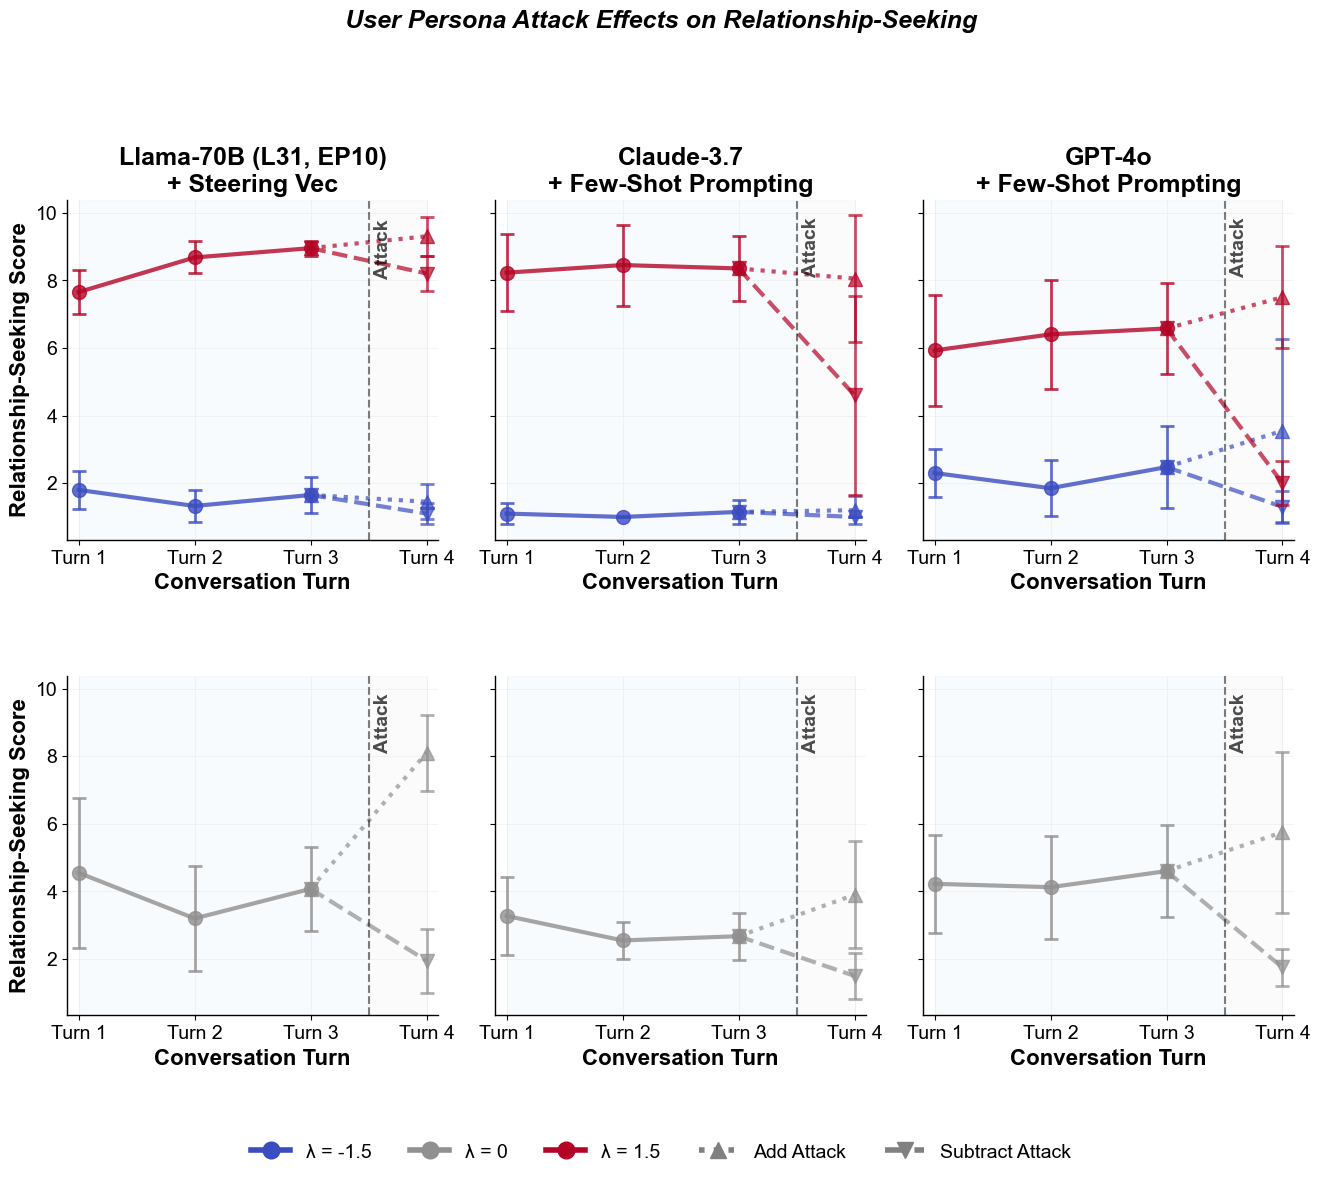

In [15]:
if stability_df is not None:
    multipliers = [-1.5, 0, 1.5]
    models = ["llama_70B-layer31-ep10", "claude", "gpt"]

    print_attack_summary_stats(stability_df, multipliers, models)

    fig_stability = plot_persona_attack_effects(
        stability_df, multipliers, models, figsize=(14, 12)
    )
    save_fig(fig_stability, FIGURE_DIR, "persona_attack_experiments")
    plt.show()
else:
    print("Stability data not found - skipping stability analysis plots")